<a href="https://colab.research.google.com/github/muhendis/Benchmarking-U-Net-and-U-Net-for-Biomedical-Image-Segmentation/blob/master/u_net%2B%2B_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Splits a multi-page TIFF file into individual pages and saves them as separate TIFF files

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import tifffile as tiff
import albumentations as A
from PIL import Image, ImageEnhance
from random import randint
from scipy.ndimage import distance_transform_edt as distance
import torchvision.transforms as T
from torchvision import transforms

# U-NET ++

In [2]:
class Block(nn.Module):
    """
    Block: A basic building block for a neural network with two convolutional layers.

    This module represents a basic building block for constructing neural network architectures. It consists of
    two convolutional layers, each followed by batch normalization and ReLU activation.

    Attributes:
        in_channels (int): The number of input channels to the block.
        middle_channels (int): The number of channels in the middle (hidden) convolutional layer.
        out_channels (int): The number of output channels from the block.

    Methods:
        - __init__(self, in_channels, middle_channels, out_channels): Initializes the Block module with the
          specified number of input, middle, and output channels.

        - conv_block(self, in_channels, out_channels): Defines the convolutional block with a 3x3 convolution,
          batch normalization, and ReLU activation.

        - forward(self, x): Forward pass through the Block module, applying the defined convolutional layers
          and returning the output tensor.

    Example:
        To create an instance of the Block module and use it for a forward pass:

        ```python
        block = Block(in_channels=64, middle_channels=128, out_channels=256)
        input_tensor = torch.randn(1, 64, 32, 32)  # Batch size of 1, 64 input channels, and 32x32 resolution
        output_tensor = block(input_tensor)
        ```
    """

    def __init__(self, in_channels, middle_channels, out_channels):
        super(Block, self).__init__()
        self.conv1 = self.conv_block(in_channels, middle_channels)
        self.conv2 = self.conv_block(middle_channels, out_channels)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        return out


class NestedUNet(nn.Module):
    """
    NestedUNet: A PyTorch implementation of a Nested U-Net architecture for semantic segmentation. (https://arxiv.org/pdf/1807.10165.pdf)

    This Nested U-Net architecture is designed for image segmentation tasks, and it consists of multiple levels
    of U-Net blocks with skip connections. It incorporates deep supervision, allowing the network to provide
    segmentation results at multiple scales.

    Attributes:
        n_channels (int): The number of input channels (e.g., for RGB images, it's 3).
        n_classes (int): The number of classes or channels in the output segmentation mask.
        **kwargs: Additional keyword arguments.

    Methods:
        - __init__(self, n_channels, n_classes, **kwargs): Initializes the NestedUNet model with the specified
          number of input channels and output classes. It also defines the architecture of the network, including
          convolutional blocks and deep supervision layers.

        - _initialize_weights(self): Initializes the weights of the convolutional layers following a Gaussian
          distribution with mean 0 and standard deviation based on the number of incoming nodes of each neuron.

        - forward(self, input): Forward pass through the Nested U-Net network, taking an input tensor and
          producing a list of segmentation outputs at multiple scales.


    Example:
        To create an instance of the NestedUNet and use it for a forward pass:

        ```python
        model = NestedUNet(n_channels=3, n_classes=1)
        input_tensor = torch.randn(1, 3, 512, 512)  # Batch size of 1, 3 input channels, and 512x512 resolution
        outputs = model(input_tensor)
        ```
    """

    def __init__(self, n_channels,n_classes,  **kwargs):
        super().__init__()

        nb_filter = [64, 128, 256, 512, 1024]

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = Block(n_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = Block(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = Block(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = Block(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = Block(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = Block(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = Block(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = Block(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = Block(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = Block(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = Block(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = Block(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = Block(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = Block(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = Block(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        #deep_supervision
        self.final1 = nn.Conv2d(nb_filter[0], n_classes, kernel_size=1)
        self.final2 = nn.Conv2d(nb_filter[0], n_classes, kernel_size=1)
        self.final3 = nn.Conv2d(nb_filter[0], n_classes, kernel_size=1)
        self.final4 = nn.Conv2d(nb_filter[0], n_classes, kernel_size=1)

        self._initialize_weights()

    def _initialize_weights(self):
        """ Initialization of the weights

        We follow here the criteria provided by Ronneberger et al. (2015). Accordingly,
        the weights should be initialized following a gaussian distribution of mean 0
        and standard deviation std = (2 / N) ** 0.5 with N being the number of incoming
        nodes of one neuron.

        Example:
        For a 3x3 convolution and 64 feature channels in the previous layer, N = 3 ** 2 * 64
        """
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                n = module.kernel_size[0] * module.kernel_size[1] * module.in_channels
                module.weight.data.normal_(0, (2. / n) ** 0.5)

    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        output1 = self.final1(x0_1)
        output2 = self.final2(x0_2)
        output3 = self.final3(x0_3)
        output4 = self.final4(x0_4)
        return [output1, output2, output3, output4] #output4 is the last output


In [4]:
import numpy as np
net = NestedUNet(n_channels=1, n_classes=1).to("cuda")
x   = torch.Tensor(np.random.rand(1, 1, 512, 512)).to("cuda")
net(x)[-1].shape

torch.Size([1, 1, 512, 512])

# Dataset

In [5]:
def create_weight_map(segmentation_map, w0=10, sigma=5):
    """
    Create a weight map for edges in the segmentation map.

    Args:
    - segmentation_map (Tensor): A binary segmentation map where edges are to be weighted.
    - w0 (float): A weight multiplier for the importance of edge pixels.
    - sigma (float): The standard deviation for the Gaussian when calculating weights.

    Returns:
    - Tensor: A weight map where edges are weighted according to their importance.
    """
    # Convert segmentation map to numpy array if it's a Tensor
    if isinstance(segmentation_map, torch.Tensor):
        segmentation_map = segmentation_map.cpu().detach().numpy()

    # Calculate the distance to the nearest cell border for all pixels
    distances = distance(segmentation_map==1)

    # Generate the weight map based on the distances
    weights = w0 * np.exp(-(distances**2 / (2*(sigma**2))))

    # Convert weights back to a PyTorch tensor
    weight_map = torch.from_numpy(weights).float()

    return weight_map


class MyToTensor:
    def __call__(self, data):
        img, label = data['image'], data['label']
        #print(img)
        ret = {
            'image': torch.from_numpy(img.copy()).unsqueeze(0)*1.0,
            'label': torch.from_numpy(label.copy()).unsqueeze(0)*1.0,
            'class_weights': create_weight_map(label).unsqueeze(0),
        }
        #print(ret.keys())
        return ret


class GrayscaleNormalization:
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        img, label = data['image'], data['label']
        #print(label)
        img=img/255
        #print(label)

        img = (img - self.mean) / self.std

        ret = {
            'image': img,
            'label': label,
        }
        return ret

class All:
  def __call__(self,data):
        img, label = data['image'], data['label']
        p=0.1
        train_transform = A.Compose([
            A.OneOf([
                A.HorizontalFlip(p = p),
                A.VerticalFlip(p = p),
            ], p = 1),
            A.ElasticTransform(p = p, alpha = 35, sigma = 5, alpha_affine = 3, approximate = True),
            A.RandomBrightnessContrast(p = p, brightness_limit = 0.15, contrast_limit = 0.15),
        ])
        for trans_i in train_transform:
            r =trans_i(image=img.astype(np.uint8),mask=label.astype(np.uint8))
            img =r["image"]
            label =r["mask"]
            #print(trans_i)
        ret = {
            'image': img,
            'label': label,
        }
        return ret


#####################
class CellDataset(Dataset):
    def __init__(self, images_dir, labels_dir,transforms=None,dataset_type="train"):
        """
        Args:
            images_dir (string): Directory with image TIFF files.
            labels_dir (string): Directory with label TIFF files.
            transform (callable, optional): Optional transform to be applied on the images and labels.
        """
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.dataset_type=dataset_type

        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.tiff')]
        self.image_files.sort()
        self.transforms=transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Load the image
        image_name = os.path.join(self.images_dir, self.image_files[idx])
        image = tiff.imread(image_name)

        # Load the corresponding label
        label_file = self.image_files[idx]
        label_name = os.path.join(self.labels_dir, label_file)
        label = tiff.imread(label_name)
        label[label == 255] = 1
        label[label == 0] = 0
        sample = {'image': image, 'label': label}
        sample=self.transforms(sample)
        return sample


def dice_score(pred, label):
    smooth = 1.  # Add a smooth term to prevent division by zero
    m1 = pred.flatten()  # Flatten predicted tensors
    m2 = label.flatten()  # Flatten label tensors
    intersection = (m1 * m2).sum()
    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

def Pixel_error(pred, label):
    ''' Computes the pixel error of the network's prediction compared to the labels corresponding to the same image
    Inputs:
        - preds: prediction tensor. Torch tensor of shape [(batch_size), H, W].
        - labels: labels tensor. Torch tensor of shape [(batch_size), H, W].

    Outputs:
        - pixel_error: float.
    '''
    pred_np  = pred.cpu().numpy()
    label_np = label.cpu().numpy()

    pixel_error = np.sum(abs(pred_np - label_np)) / pred_np.size

    return pixel_error


# Dataloader

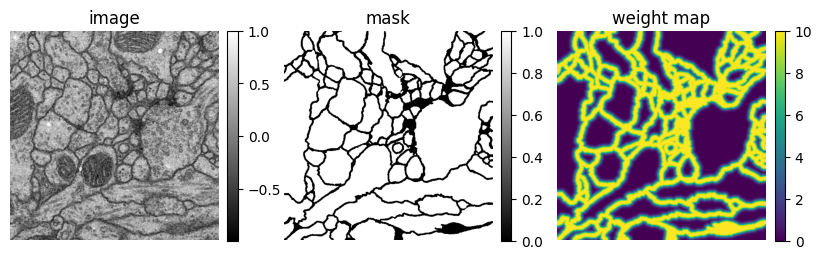

In [6]:
torch.manual_seed(13)  # Set the random seed for reproducibility

train_transform = transforms.Compose([
    All(),
    GrayscaleNormalization(mean=0.5, std=0.5),
    MyToTensor(),
])
val_transform = transforms.Compose([
    GrayscaleNormalization(mean=0.5, std=0.5),
    MyToTensor(),
])

train_dataset = CellDataset(images_dir='./splitted-images/train-volume',
                                 labels_dir='./splitted-images/train-labels',
                                transforms=train_transform,
                            dataset_type="train")
val_dataset = CellDataset(images_dir='./splitted-images/val-volume',
                                 labels_dir='./splitted-images/val-labels',
                                transforms=val_transform,
                          dataset_type="val")
batch_size = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


#------------------------------------------------------------------------------------------------------------------------------------
from matplotlib import pyplot as plt
for i, batch in enumerate(val_loader):
  # Plot results
  w,img=batch["class_weights"][0].numpy(),batch["image"][0][0].numpy()
  fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 10));

  im = ax[0].imshow(img, 'gray')
  plt.colorbar(im, ax = ax[0], fraction = 0.046, pad = 0.04)
  ax[0].axis('off')
  ax[0].set_title('image')

  im = ax[1].imshow(batch["label"][0][0].numpy(),'gray')
  plt.colorbar(im, ax = ax[1], fraction = 0.046, pad = 0.04)
  ax[1].axis('off')
  ax[1].set_title('mask')

  im = ax[2].imshow(w[0])
  plt.colorbar(im, ax = ax[2], fraction = 0.046, pad = 0.04)
  ax[2].axis('off');
  ax[2].set_title('weight map');

  break


# Train

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs,loss_dict,dice_dict,pixel_dict):
    # Eğitim ve doğrulama kayıplarını saklayacak listeler

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()  # Modeli eğitim moduna al
        total_train_loss = 0.0
        total_train_dice = 0.0
        total_train_pixel_error = 0.0
        for i, batch in enumerate(train_loader):

            optimizer.zero_grad()

            inputs, labels = batch['image'].to(device), batch['label'].to(device)
            out = net(inputs.float())

            criterion=torch.nn.BCEWithLogitsLoss (weight = batch['class_weights'].to(device))
            loss = 0
            for out_i in out:
                loss += criterion(out_i, labels.float())
            loss /= len(out)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            out = F.sigmoid(out[-1])

            dice = dice_score(out > 0.5, labels)
            total_train_dice=total_train_dice+dice.cpu().detach().numpy().tolist()

            pixel_er=Pixel_error(out > 0.5, labels).tolist()
            total_train_pixel_error=total_train_pixel_error+pixel_er


        # Calculate average metrics for this epoch
        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_dice = total_train_dice / len(train_loader)
        avg_train_pixel_error = total_train_pixel_error / len(train_loader)

        loss_dict["train"].append(avg_train_loss)
        dice_dict["train"].append(avg_train_dice)
        pixel_dict["train"].append(avg_train_pixel_error)

        # Doğrulama kaybını hesapla
        model.eval()
        total_val_loss = 0.0
        total_val_dice = 0.0
        total_val_pixel_eror=0
        with torch.no_grad():
            for i, batch in enumerate(val_loader):
                inputs, labels = batch['image'].to(device), batch['label'].to(device)
                out = net(inputs.float())
                criterion=torch.nn.BCEWithLogitsLoss (weight = batch['class_weights'].to(device))
                loss = 0
                for out_i in out:
                    loss += criterion(out_i, labels.float())
                loss /= len(out)

                total_val_loss += loss.item()
                out = F.sigmoid(out[-1])

                dice = dice_score(out > 0.5, labels)
                total_val_dice=total_val_dice+dice.cpu().detach().numpy().tolist()

                pixel_er=Pixel_error(out > 0.5, labels).tolist()
                total_val_pixel_eror=total_val_pixel_eror+pixel_er

        # Calculate average validation metrics
        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_dice = total_val_dice / len(val_loader)
        avg_val_pixel_error = total_val_pixel_eror/len(val_loader)

        loss_dict["val"].append(avg_val_loss)
        dice_dict["val"].append(avg_val_dice)
        pixel_dict["val"].append(avg_val_pixel_error)

        # Print training and validation results
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"- Training Loss: {avg_train_loss:.4f}, Dice Score: {avg_train_dice:.4f}, Pixel Error: {avg_train_pixel_error:.4f}")
        print(f"- Validation Loss: {avg_val_loss:.4f}, Dice Score: {avg_val_dice:.4f}, Pixel Error: {avg_val_pixel_error:.4f}")

        # Scheduler güncellemesi
        scheduler.step(avg_val_loss)

        # En iyi modeli kaydet
        if avg_val_loss < best_val_loss:
            print(f"best epoch {epoch}")
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), './unet++_best_model.pth')


#---------------------------------------------------------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
from torch import optim
from torch.optim.lr_scheduler import StepLR
net = NestedUNet(n_channels=1, n_classes=1).to(device)

training_loss = []
val_loss = []
epoch_number=100
# Initialize dictionaries to keep track of metrics
loss_dict = {"train": [], "val": [], "test": []}
dice_dict = {"train": [], "val": [], "test": []}
pixel_dict = {"train": [], "val": [], "test": []}

# Model eğitimi başlat ve kayıpları al
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.99, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=100, verbose=True)

train_model(net, train_loader, val_loader, optimizer, scheduler, num_epochs=epoch_number,loss_dict=loss_dict,dice_dict=dice_dict,pixel_dict=pixel_dict)


Epoch 1/100
- Training Loss: 3.5706, Dice Score: 0.5526, Pixel Error: 0.4975
- Validation Loss: 2.9067, Dice Score: 0.7042, Pixel Error: 0.3633
best epoch 0
Epoch 2/100
- Training Loss: 2.5775, Dice Score: 0.8200, Pixel Error: 0.2480
- Validation Loss: 2.3987, Dice Score: 0.8588, Pixel Error: 0.2021
best epoch 1
Epoch 3/100
- Training Loss: 2.2998, Dice Score: 0.8689, Pixel Error: 0.1916
- Validation Loss: 2.0930, Dice Score: 0.8867, Pixel Error: 0.1683
best epoch 2
Epoch 4/100
- Training Loss: 2.1439, Dice Score: 0.8818, Pixel Error: 0.1762
- Validation Loss: 1.9931, Dice Score: 0.8932, Pixel Error: 0.1604
best epoch 3
Epoch 5/100
- Training Loss: 2.1016, Dice Score: 0.8819, Pixel Error: 0.1753
- Validation Loss: 1.9973, Dice Score: 0.8844, Pixel Error: 0.1701
Epoch 6/100
- Training Loss: 2.0096, Dice Score: 0.8822, Pixel Error: 0.1730
- Validation Loss: 1.9891, Dice Score: 0.8776, Pixel Error: 0.1776
best epoch 5
Epoch 7/100
- Training Loss: 1.9649, Dice Score: 0.8852, Pixel Error: 0

In [ ]:
# save outputs
import json
with open('unet_loss_dict.json', 'w') as json_file:
    json.dump(loss_dict, json_file)
with open('unet_dice_dict.json', 'w') as json_file:
    json.dump(dice_dict, json_file)
with open('unet_pixel_error_dict.json', 'w') as json_file:
    json.dump(pixel_dict, json_file)

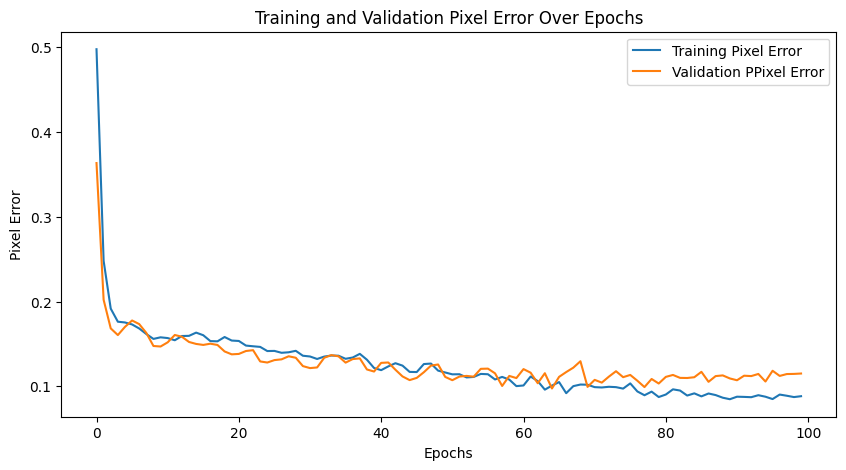

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(pixel_dict['train'], label='Training Pixel Error')
plt.plot(pixel_dict['val'], label='Validation PPixel Error')

plt.title('Training and Validation Pixel Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Pixel Error')
plt.legend()

plt.show()


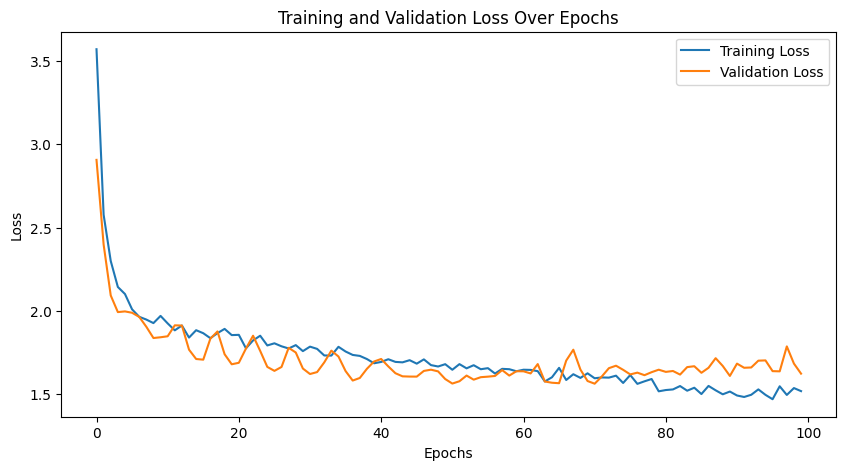

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_dict['train'], label='Training Loss')
plt.plot(loss_dict['val'], label='Validation Loss')

# Grafiğe başlık ve etiketler ekleyin.
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Grafiği gösterin.
plt.show()


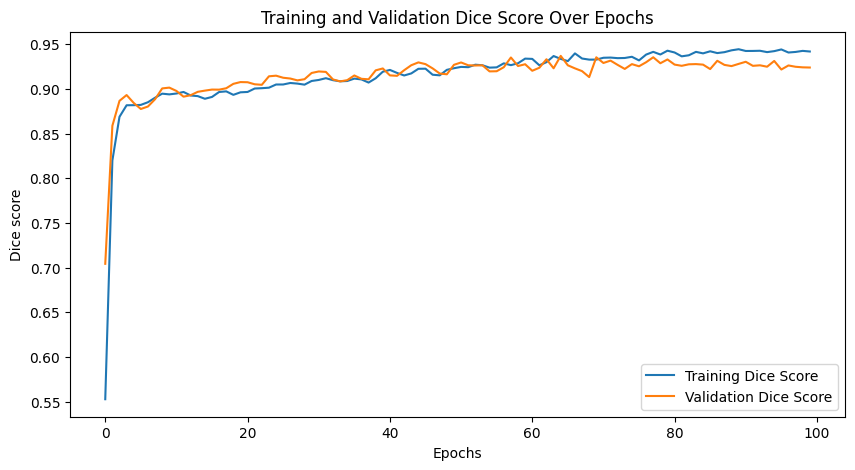

In [ ]:
import matplotlib.pyplot as plt

# loss_dict sözlüğüne kayıp değerlerini ekleyin. Bu örnekler, her epoch için rastgele üretilmiş değerlerdir.
# Gerçek durumda, bu değerler eğitim döngüsünden elde edilen gerçek kayıp değerleri olmalıdır.
# Kayıp değerlerini çizmek için bir grafik oluşturun.
plt.figure(figsize=(10, 5))
plt.plot(dice_dict['train'], label='Training Dice Score')
plt.plot(dice_dict['val'], label='Validation Dice Score')

# Grafiğe başlık ve etiketler ekleyin.
plt.title('Training and Validation Dice Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice score')
plt.legend()

# Grafiği gösterin.
plt.show()


# INFERENCE

In [ ]:
import os
import cv2
import tifffile as tiff
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


def net_test(net, loader, path="./"):
    net.eval()
    with torch.no_grad():
        for i, batch in enumerate(loader):
            try:
                inputs, labels = batch['image'].to(device), batch['label'].to(device)
                outputs = net(inputs.float())
                output=torch.sigmoid(outputs[-1]).cpu()[0].numpy()[0]
                output[output < 0.5] = 0
                output[output >= 0.5] = 1
                output=np.uint8(output * 255)
                cv2.imwrite(os.path.join(path, f"{i}.png"), output)
                gt=np.uint8(batch['label'][0].data.numpy()[0]*255)
                cv2.imwrite(os.path.join(path, f"{i}_gt.png"), gt)

            except Exception as e:
                print(f"Error processing batch {i}: {e}")


# Set up directories
directories = ['./train', './test', './val']
for dir in directories:
    os.makedirs(dir, exist_ok=True)

torch.manual_seed(13)
device = "cuda" if torch.cuda.is_available() else "cpu"



val_transform = transforms.Compose([
    GrayscaleNormalization(mean=0.5, std=0.5),
    MyToTensor(),
])


# Define datasets and loaders
datasets = {
     'train': CellDataset(images_dir='./splitted-images/train-volume',
                                 labels_dir='./splitted-images/train-labels',
                                transforms=val_transform,
                            dataset_type="val"),
     'val': CellDataset(images_dir='./splitted-images/val-volume',
                                 labels_dir='./splitted-images/val-labels',
                                transforms=val_transform,
                          dataset_type="val"),
     'test': CellDataset(images_dir='./splitted-images/test-volume',
                                 labels_dir='./splitted-images/test-labels',
                                transforms=val_transform,
                          dataset_type="val")
}



loaders = {x: DataLoader(datasets[x], batch_size=1, shuffle=False) for x in datasets}

# Load the best model
net = NestedUNet(n_channels=1, n_classes=1).to("cuda")
net.load_state_dict(torch.load('./unet++_best_model.pth'))
net.eval()


# Test the model
for phase in ['train', 'val', 'test']:
    net_test(net, loaders[phase], path=f"./{phase}/")


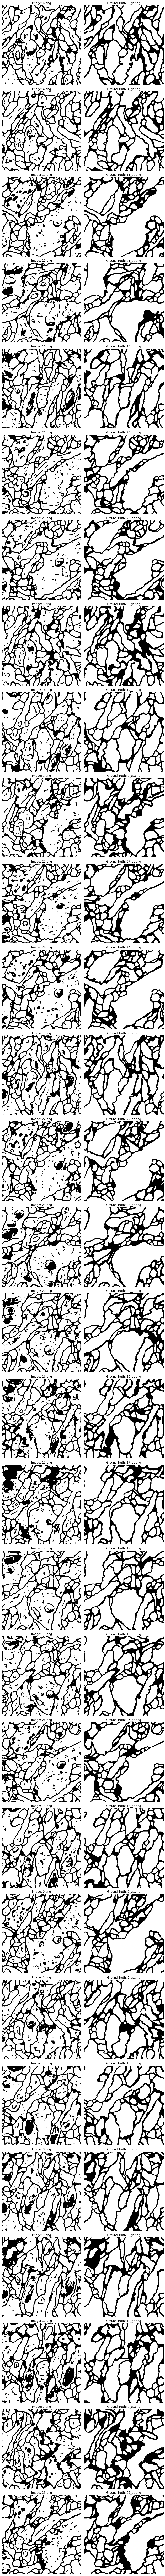

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def read_and_display_images(folder_path):
    # List all files in the directory
    files = os.listdir(folder_path)

    # Filter out the main images and their corresponding ground truth images
    images = [f for f in files if '.png' in f and '_gt' not in f]
    gt_images = [f.replace('.png', '_gt.png') for f in images]

    # Set up the plot
    fig, axes = plt.subplots(len(images), 2, figsize=(10, 5 * len(images)))

    # Adjust axes for single image case
    if len(images) == 1:
        axes = [axes]

    # Loop through each image and its ground truth
    for i, (img_name, gt_name) in enumerate(zip(images, gt_images)):
        img_path = os.path.join(folder_path, img_name)
        gt_path = os.path.join(folder_path, gt_name)

        # Read the images
        image = mpimg.imread(img_path)
        gt_image = mpimg.imread(gt_path)

        # Display the image
        axes[i][0].imshow(image, cmap='gray')
        axes[i][0].set_title(f'Image: {img_name}')
        axes[i][0].axis('off')

        # Display the ground truth
        axes[i][1].imshow(gt_image, cmap='gray')
        axes[i][1].set_title(f'Ground Truth: {gt_name}')
        axes[i][1].axis('off')

    plt.tight_layout()
    plt.show()

# Replace 'path_to_folder' with the path to the directory containing your '.png' and '_gt.png' files.
read_and_display_images('/content/test')


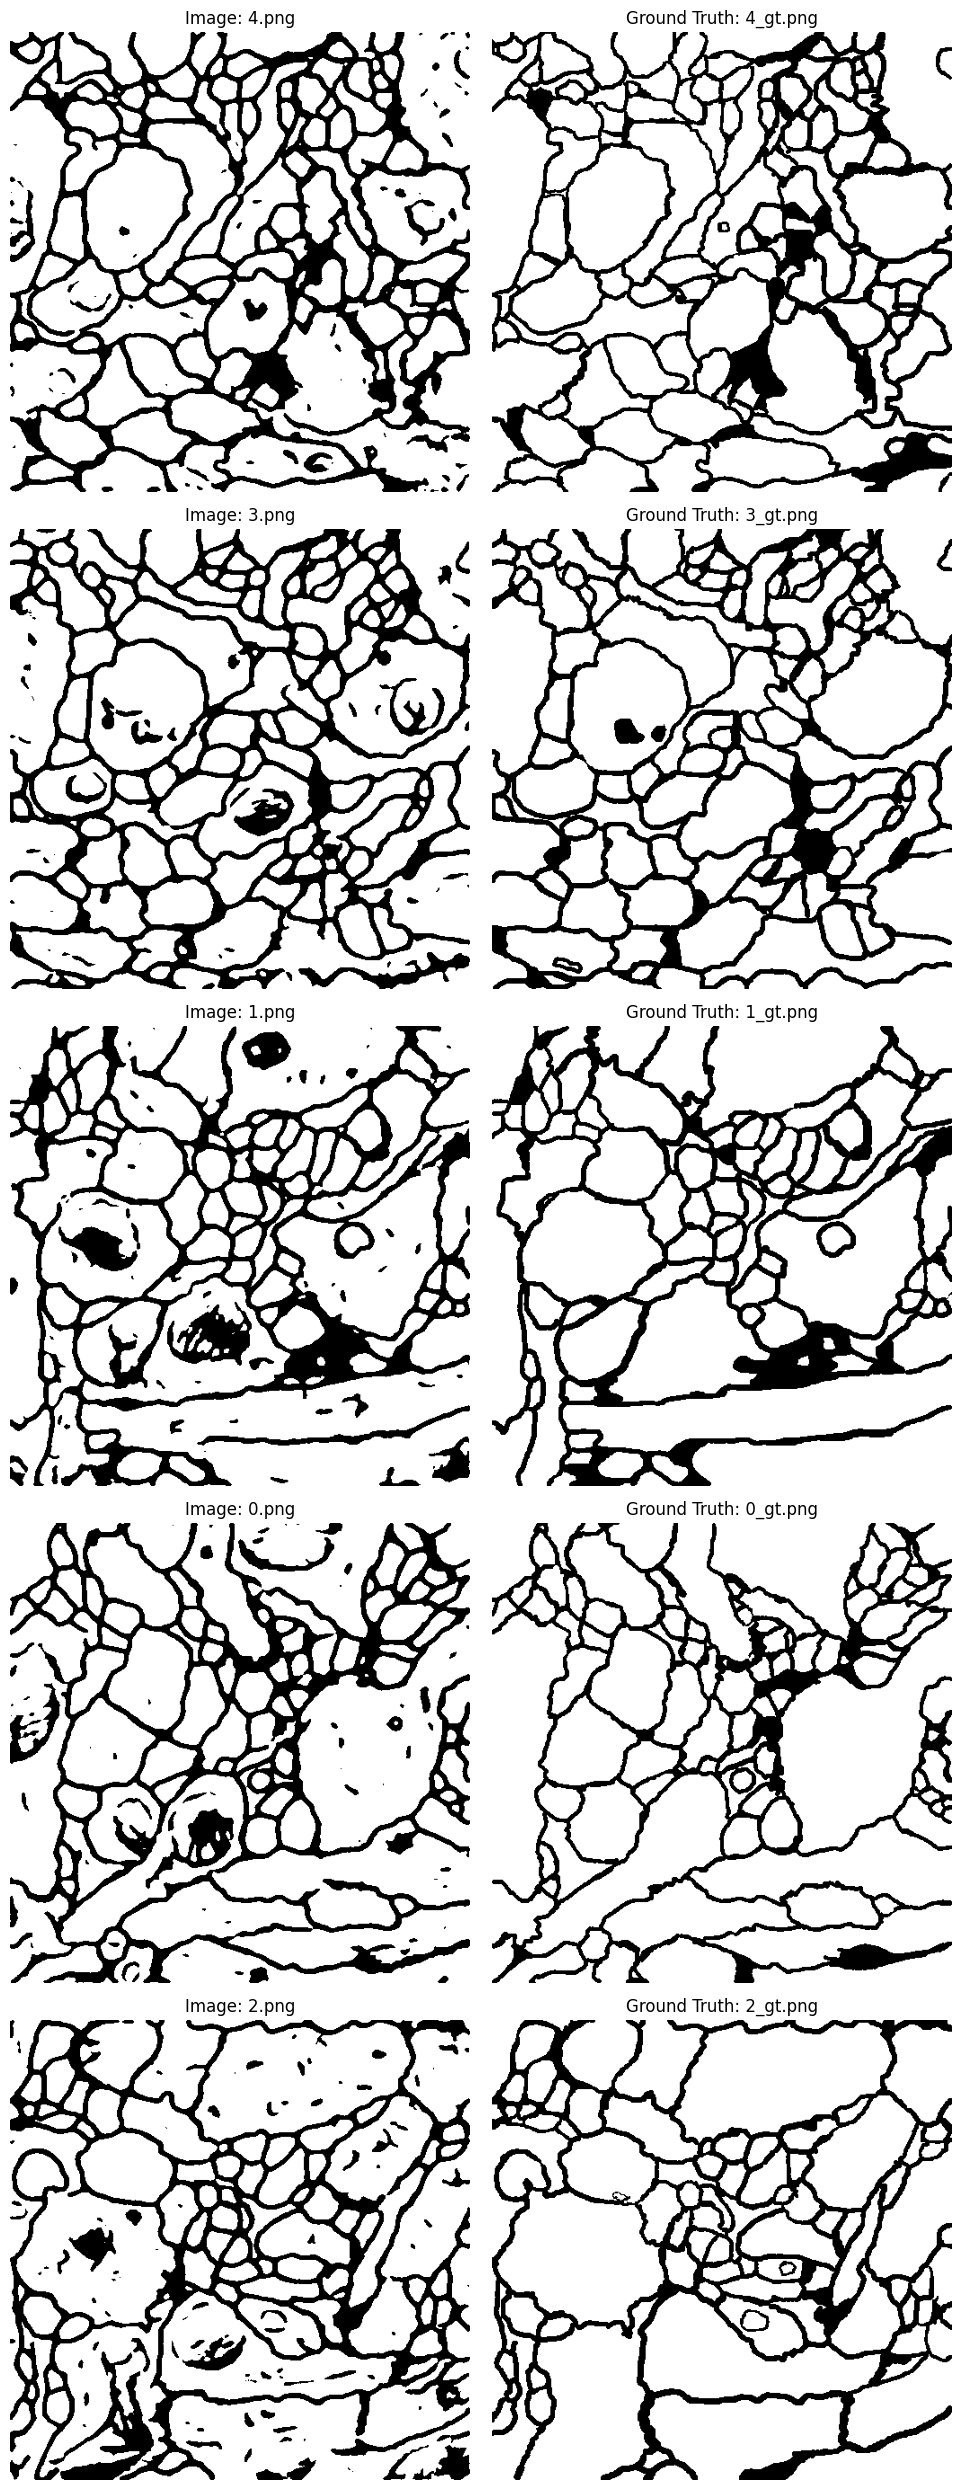

In [ ]:
read_and_display_images('/content/val')

In [ ]:
!zip -r val.zip val/
!zip -r train.zip train/
!zip -r test.zip test/

  adding: val/ (stored 0%)
  adding: val/4.png (deflated 16%)
  adding: val/2_gt.png (deflated 12%)
  adding: val/3.png (deflated 15%)
  adding: val/1.png (deflated 13%)
  adding: val/0.png (deflated 15%)
  adding: val/4_gt.png (deflated 15%)
  adding: val/3_gt.png (deflated 12%)
  adding: val/1_gt.png (deflated 15%)
  adding: val/0_gt.png (deflated 16%)
  adding: val/2.png (deflated 12%)
  adding: train/ (stored 0%)
  adding: train/24_gt.png (deflated 13%)
  adding: train/6.png (deflated 13%)
  adding: train/4.png (deflated 13%)
  adding: train/11.png (deflated 14%)
  adding: train/21.png (deflated 13%)
  adding: train/11_gt.png (deflated 14%)
  adding: train/20_gt.png (deflated 17%)
  adding: train/10.png (deflated 15%)
  adding: train/2_gt.png (deflated 16%)
  adding: train/10_gt.png (deflated 14%)
  adding: train/3.png (deflated 16%)
  adding: train/23_gt.png (deflated 13%)
  adding: train/14.png (deflated 13%)
  adding: train/1.png (deflated 17%)
  adding: train/7_gt.png (deflated

In [ ]:
#!rm -rf train
#!rm -rf  test
#!rm -rf val

In [ ]:
!pip freeze

absl-py==1.4.0
aiohttp==3.9.1
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.3.1
altair==4.2.2
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.5.0
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.1.0
audioread==3.0.1
autograd==1.6.2
Babel==2.14.0
backcall==0.2.0
beautifulsoup4==4.11.2
bidict==0.22.1
bigframes==0.17.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.2
bqplot==0.12.42
branca==0.7.0
build==1.0.3
CacheControl==0.13.1
cachetools==5.3.2
catalogue==2.0.10
certifi==2023.11.17
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.7
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.0
colorcet==3.0.1
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.0
cryptography==41.0.7
cufflinks==0.17.3
cupy-cuda12x==12.2.0
cvxopt==1.3.2
cvxpy==1.3.2
cycler==0.12.1
c